In [55]:
# import libraries
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

In [56]:
# load data and merge data
poi_metrics = pd.read_csv("/Users/leofeingold/Documents/GitHub/openbiomechanics/baseball_hitting/data/poi/poi_metrics.csv")
metadata = pd.read_csv("/Users/leofeingold/Documents/GitHub/openbiomechanics/baseball_hitting/data/metadata.csv")

poi_metrics = poi_metrics.merge(metadata[["session_swing", "session_mass_lbs", "bat_weight_oz"]], on="session_swing")

In [57]:
# select columns pertaining to the torso
#print(poi_metrics.columns.tolist())

desired_columns = []

for column in poi_metrics.columns.tolist():
    if "torso" in column or (column == 'bat_speed_mph_max_x'): #or (column == 'session_mass_lbs') or (column == 'bat_weight_oz'):
        desired_columns.append(column)

print(desired_columns)

['bat_torso_angle_connection_x', 'bat_speed_mph_max_x', 'bat_torso_angle_ds_x', 'bat_torso_angle_ds_y', 'bat_torso_angle_ds_z', 'torso_angle_fm_x', 'torso_angle_fm_y', 'torso_angle_fm_z', 'torso_angle_fp_x', 'torso_angle_fp_y', 'torso_angle_fp_z', 'torso_angle_hs_x', 'torso_angle_hs_y', 'torso_angle_hs_z', 'torso_angular_velocity_fm_x', 'torso_angular_velocity_fp_x', 'torso_angular_velocity_maxhss_x', 'torso_angular_velocity_stride_max_x', 'torso_angular_velocity_seq_max_x', 'torso_angular_velocity_swing_max_x', 'torso_fm_x', 'torso_fm_y', 'torso_fm_z', 'torso_launchpos_x', 'torso_launchpos_y', 'torso_launchpos_z', 'torso_loadedpos_x', 'torso_load_max_x', 'torso_pelvis_fm_x', 'torso_pelvis_launchpos_x', 'torso_pelvis_loadedpos_x', 'torso_pelvis_load_max_x', 'torso_pelvis_stride_max_x', 'torso_pelvis_stride_max_y', 'torso_pelvis_stride_max_z', 'torso_pelvis_swing_max_x', 'torso_stride_max_x', 'torso_stride_max_y', 'torso_stride_max_z', 'torso_swing_max_x', 'torso_swing_max_y', 'torso_sw

In [58]:
# handle na values
poi_metrics = poi_metrics[desired_columns].dropna()
print(poi_metrics.shape)

(677, 42)


In [59]:
X = poi_metrics.drop('bat_speed_mph_max_x', axis=1)
X = X.apply(pd.to_numeric, errors='coerce')
cols_with_na = X.columns[X.isna().any()].tolist()
print(f"Columns with NA values: {cols_with_na}")
X = X.dropna(axis=1, how='any')
print(f"X Shape: {X.shape}")
y = poi_metrics["bat_speed_mph_max_x"]

Columns with NA values: []
X Shape: (677, 41)


In [60]:
# scale values for better regression results
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [61]:
# train the model using XGBRegressor
simple_model = xgb.XGBRegressor()
simple_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
# make predictions
y_pred = simple_model.predict(X_test)

# evaluate model
mse_score = mean_squared_error(y_test, y_pred)
mae_score = mean_absolute_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)

print(f"MSE: {mse_score}")
print(f"MAE: {mae_score}")
print(f"r^2: {r2score}")

MSE: 10.37887923957246
MAE: 2.3623806334551642
r^2: 0.5802672954862814


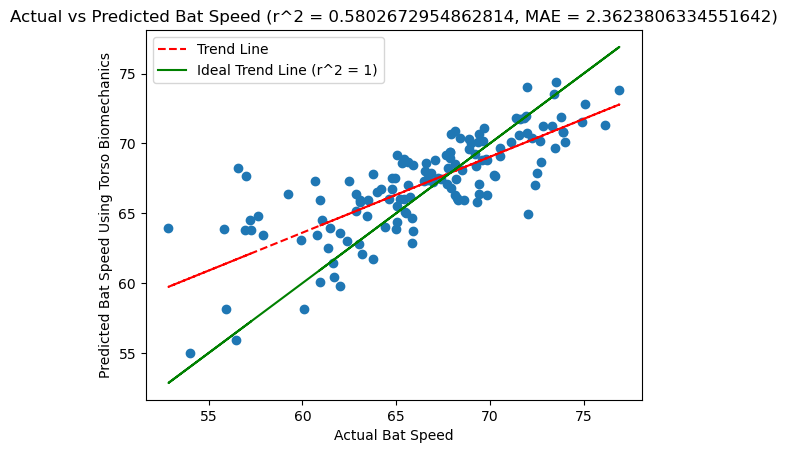

[12:53:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1717011580408/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


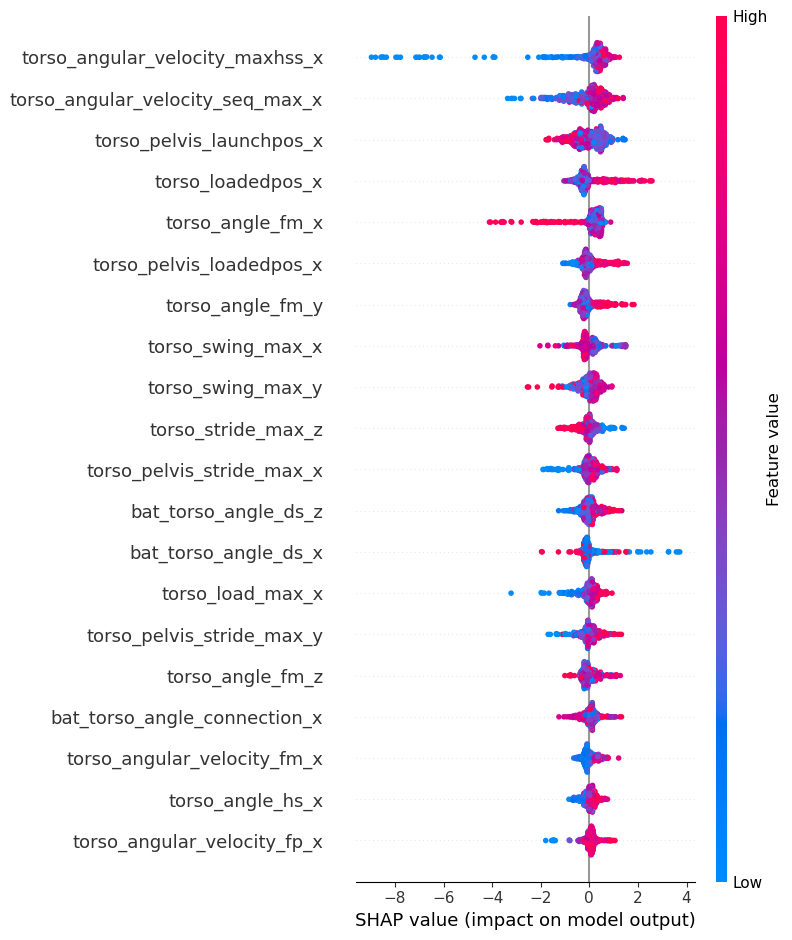

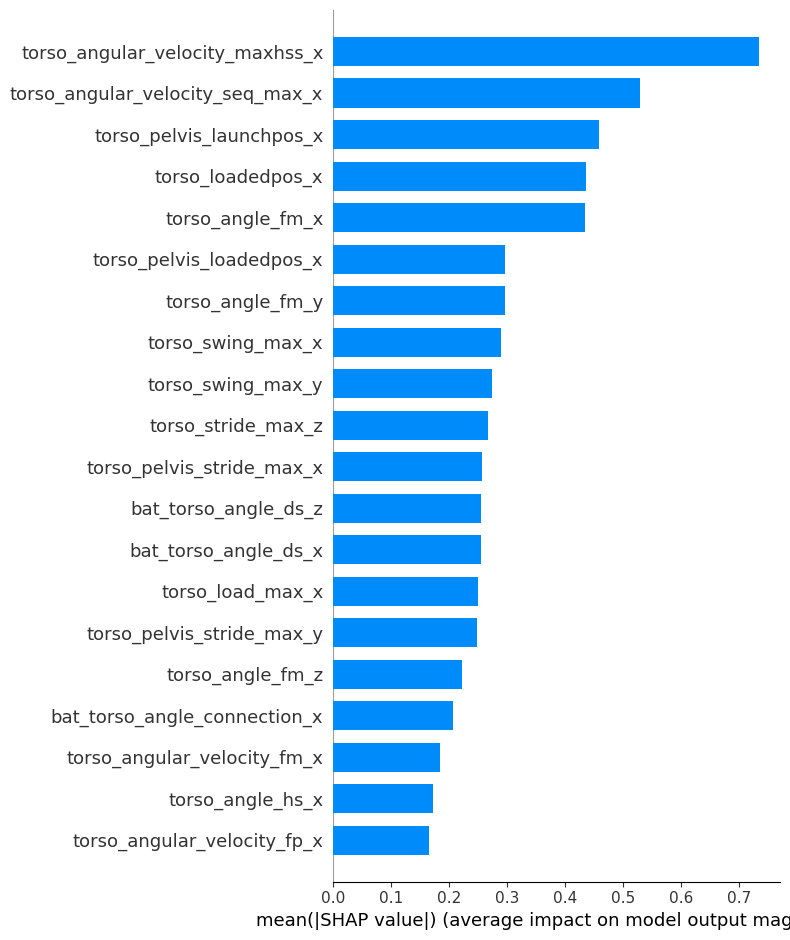

In [63]:
# plot results

z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)


plt.scatter(y_test, y_pred)
plt.xlabel("Actual Bat Speed")
plt.ylabel("Predicted Bat Speed Using Torso Biomechanics")
plt.plot(y_test, p(y_test), "r--", label="Trend Line")
plt.plot(y_test, y_test, "g-", label="Ideal Trend Line (r^2 = 1)")
plt.title(f"Actual vs Predicted Bat Speed (r^2 = {r2score}, MAE = {mae_score})")
plt.legend()
plt.show()

# determine feature importance using SHAP
explainer = shap.Explainer(simple_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

# plot data for important features using SHAP
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar")